# Aug ??st, 2021 (play boot)

**Motivation**: SVINET <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 3
p = 20
figs_dir = [
    mice.cfg.results_dir,
    'SVINET',
    'figs_combined',
    '-'.join([
        f"{svinet_props.get('graph_type', 'real')}",
        f"p{p}",
        f"k{k}",
    ]),
]
figs_dir = pjoin(*figs_dir)
os.makedirs(figs_dir, exist_ok=True)
print(figs_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k3

## Align loaded fits using svinet.gam

In [3]:
svinet = SVINET(mice, k, p, 'sub-SLC')
result = align_svinet_group(mice, k=k, p=p, **svinet_props)
list(result)

current expt: 'p20'

['perms', 'gam', 'pi', 'gamma_all', 'svinet_all']

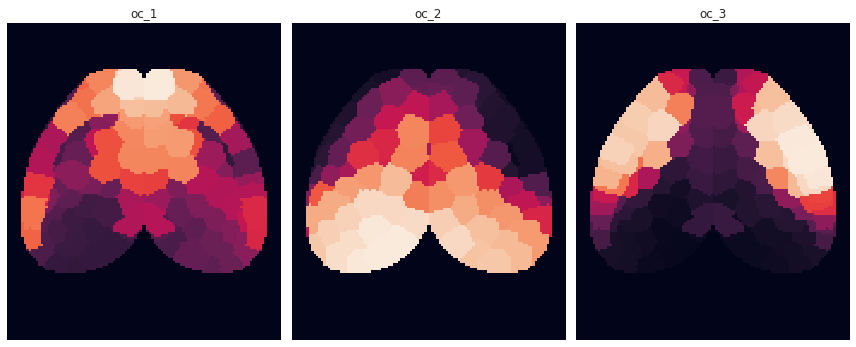

In [4]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(result['pi'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

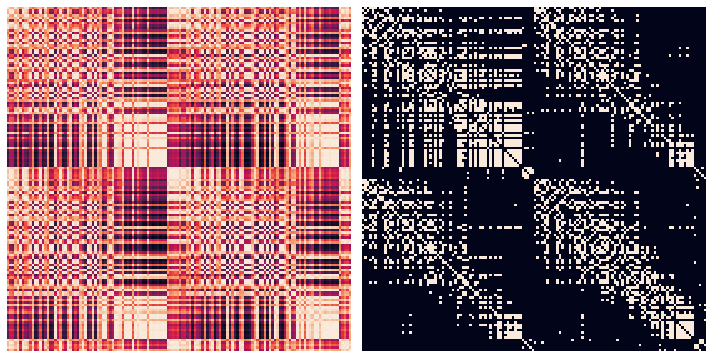

In [5]:
fig, axes = create_figure(1, 2, (10, 7))
d = sp_dist.pdist(result['pi'].T, metric='cosine')
d = sp_dist.squareform(d)
im = axes[0].imshow(dist2sim(d))

axes[1].imshow(svinet.adjacencies[20].astype(bool))
remove_ticks(axes)
plt.show()

In [6]:
fix_idx = np.concatenate([
    np.array(list(v.values())).reshape(1, -1)
    for v in result['perms'].values()
])
ctr = {}
for i in range(k):
    ctr[i] = collections.Counter(fix_idx[:, i]).most_common()
ctr

{0: [(0, 16), (2, 7), (1, 7)], 1: [(1, 16), (0, 14)], 2: [(2, 23), (1, 7)]}

In [ ]:
### Run below to see if they are aligned goodly

  0%|          | 0/30 [00:00<?, ?it/s]

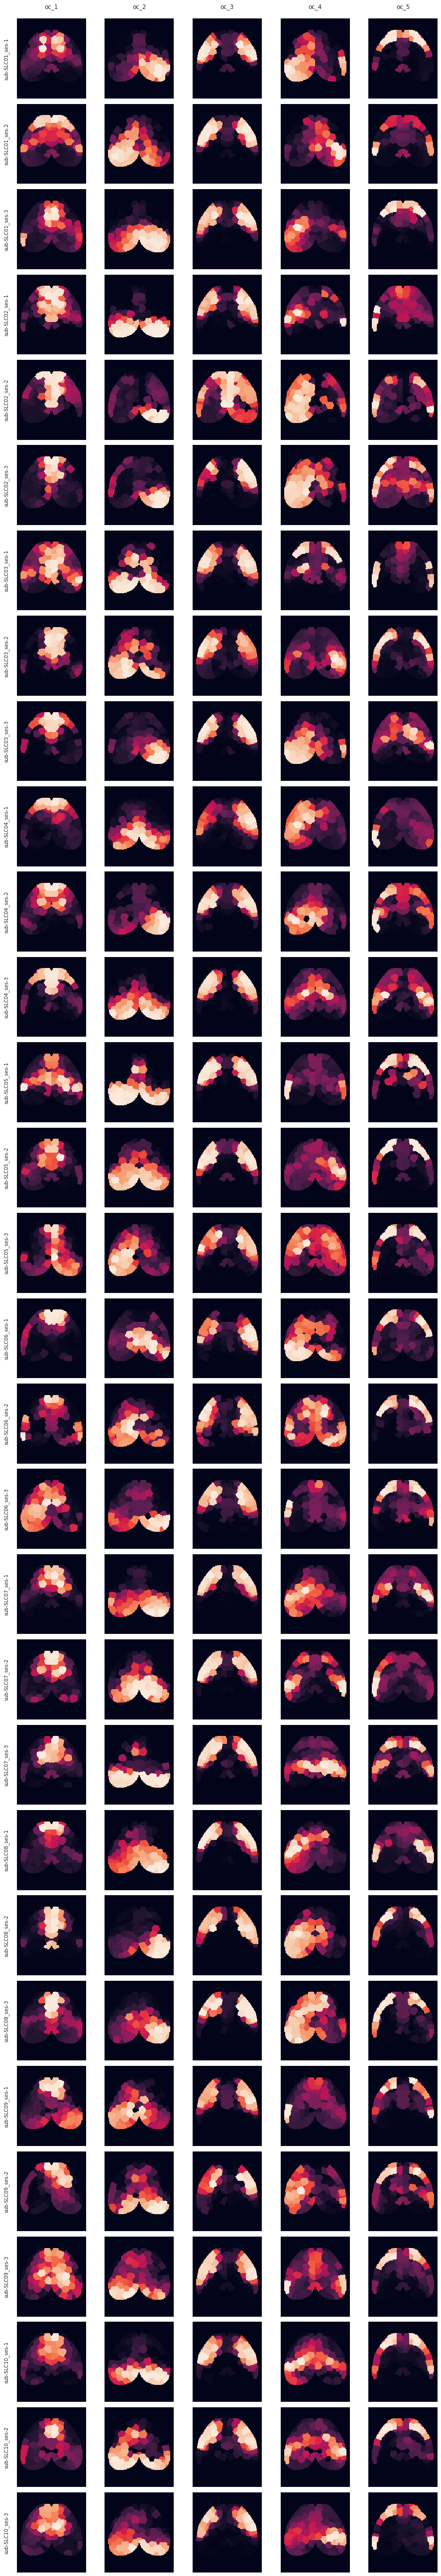

In [8]:
nrows = len(result['gamma_all'])
fig, axes = create_figure(nrows, k, (13, 2.4 * nrows))

for i, (key, gam) in tqdm(enumerate(result['gamma_all'].items()), total=nrows):
    gam_arr = svinet.pi2arr(gam, cortex_only=True)
    for j, idx in enumerate(range(1, k + 1)):
        im = axes[i, j].imshow(gam_arr[idx], cmap='rocket', vmin=0)
        # plt.colorbar(im, ax=axes[i, j], shrink=0.5)
        if i == 0:
            axes[i, j].set_title(f"oc_{idx}\n")
        if j == 0:
            axes[i, j].set_ylabel(f"{key}\n")
remove_ticks(axes)
plt.show()

## All animals and sessions

In [8]:
num_draws = 10000
rng = get_rng()

dlist = []
for sub in tqdm(mice.cfg.sub_ids, leave=False):
    samples = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        _df = result['svinet_all'][key].pi_cut_df
        intervals = _df.interval.unique()
        data = _df.percent.to_numpy().reshape(-1, k, len(intervals))
        data = data[:, list(result['perms'][key].values()), :]
        s = np.zeros((num_draws, *data.shape[1:]))
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                s[:, i, j] = rng.choice(
                    a=data[:, i, j],
                    size=num_draws,
                    replace=True,
                )
        samples.append(np.expand_dims(s, axis=0))
    samples = np.concatenate(samples)
    samples = samples.mean(0)

    for j in range(samples.shape[2]):
        for i in range(samples.shape[1]):
            dlist.append({
                'key': [mice.get_key(sub)] * num_draws,
                'interval': [intervals[j]] * num_draws,
                'oc_idx': [i + 1] * num_draws,
                'k': [k] * num_draws,
                'mean': samples[:, i, j],
            })
df_means = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
df_means

,key,interval,oc_idx,k,mean
0,sub-SLC01,"(0.0, 0.1]",1,7,23.467841
1,sub-SLC01,"(0.0, 0.1]",1,7,27.701654
2,sub-SLC01,"(0.0, 0.1]",1,7,22.318841
3,sub-SLC01,"(0.0, 0.1]",1,7,20.491453
4,sub-SLC01,"(0.0, 0.1]",1,7,24.976852
...,...,...,...,...,...
6999995,sub-SLC10,"(0.9, 1.0]",7,7,10.067340
6999996,sub-SLC10,"(0.9, 1.0]",7,7,15.530303
6999997,sub-SLC10,"(0.9, 1.0]",7,7,19.615616
6999998,sub-SLC10,"(0.9, 1.0]",7,7,14.447457


In [10]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

In [11]:
nrows = 2
ncols = int(np.ceil(len(intervals) / nrows))
fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', False, False)

for ax, intvl in zip(axes.ravel(), df_means.interval.unique()):
    _df = df_means.loc[
        (df_means.loc[:, 'interval'] == intvl) &
        (df_means.loc[:, 'k'] == k)
    ]
    sns.kdeplot(
        data=_df,
        x='mean',
        hue='oc_idx',
        fill=True,
        alpha=0.05,
        lw=2,
        palette=svinet.colors,
        ax=ax,
    )
    ax_tx = ax.twinx()
    ax_tx.set_ylim(ax.get_ylim())
    sns.boxplot(
        data=_df,
        x='mean',
        y='oc_idx',
        palette=svinet.colors,
        dodge=True,
        orient='h',
        width=0.6,
        whis=[2.5, 97.5],
        fliersize=1,
        showmeans=True,
        meanprops=meanprops,
        ax=ax_tx,
        **props,
    )
    ax_tx.set_ylabel('')
    ax.axvline(0, color='k', lw=0.5, ls='--')
    
    ax.set_title(f"bin: {intvl}", y=1.02, fontsize=15)
    if j == 0:
        ax.set_ylabel('mice\n', fontsize=15)
    else:
        ax.set_ylabel('')

file = pjoin(figs_dir, f"kde-box-animals-means_ses-combined_bins{len(intervals)}.pdf")
fig.savefig(file, bbox_inches='tight')
plt.close()

In [16]:
whisk = {
    10.0: [5.0, 95.0],
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.01: [0.005, 99.995],
}
figs = []
sups = []
for ci, whisk_val in whisk.items():
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(df_means.interval.unique()):
        _df = df_means.loc[
            (df_means.loc[:, 'interval'] == intvl) &
            (df_means.loc[:, 'k'] == k)
        ]
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = pjoin(figs_dir, f"kde-box-group_bins{len(intervals)}.pdf")
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

done.

In [13]:
whisk = {
    10.0: [5.0, 95.0],
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.01: [0.005, 99.995],
}
figs = []
sups = []
for ci, whisk_val in whisk.items():
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(df_means.interval.unique()):
        _df = df_means.loc[
            (df_means.loc[:, 'interval'] == intvl) &
            (df_means.loc[:, 'k'] == k)
        ]
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='key',
            fill=True,
            alpha=0.05,
            lw=2,
            palette='deep',
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='key',
            palette='deep',
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            fliersize=1,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = pjoin(figs_dir, f"kde-box-group_ocs-combined_bins{len(intervals)}.pdf")
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

done.

## BOOTSTRAP

In [7]:
import re

def _extract_seed(x):
    x = next(e for e in str(x).split('-') if 'seed' in e)
    x = re.sub(r"\D", "", x)
    return int(x)

In [8]:
# find shared seeds

seeds_shared = set(range(1, 1000 + 1))
for sub in mice.cfg.sub_ids:
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df
        s = list(map(_extract_seed, df['run']))
        seeds_shared.intersection_update(set(s))
len(seeds_shared)

1000

In [9]:
intervals = None

data_all = []
for sub in tqdm(mice.cfg.sub_ids):
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df.copy()
        if intervals is None:
            intervals = df.interval.unique()
        df = pd.concat([pd.DataFrame(columns=['seed']), df], axis=1)
        df['seed'] = list(map(_extract_seed, df['run']))
        df = df.loc[df['seed'].isin(seeds_shared)]
        df = df.set_index([df['seed'], df['oc_idx'], df['interval']])
        df = df.drop(columns=['run', 'seed', 'oc_idx', 'interval', 'count'])
        data = df.unstack().values
        data = data.reshape((len(seeds_shared), k, len(intervals)))
        data_ses.append(np.expand_dims(data, axis=0))
    data_ses = np.concatenate(data_ses)
    data_all.append(np.expand_dims(data_ses, axis=0))
data_all = np.concatenate(data_all)
data_all.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 3, 1000, 3, 10)

In [13]:
n_boot = 10000
booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
    avg_seeds=True,
)
booted.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

(100000, 3, 10)

In [16]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    10.0: [5.0, 95.0],
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.01: [0.005, 99.995],
}
figs = []
sups = []
for ci, whisk_val in whisk.items():
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * 10 * n_boot,
                'oc_idx': [i + 1] * 10 * n_boot,
                'mean': booted[..., i, j].ravel(),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = pjoin(figs_dir, f"kde-box-group_seeds-avg_bins{len(intervals)}-boot{n_boot:1.0e}.pdf")
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

done.

In [22]:
n_boot = int(1e6)
booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
    avg_seeds=True,
)
booted.shape

  0%|          | 0/1000000 [00:00<?, ?it/s]

(10000000, 3, 10)

In [23]:
ci = [99.9, 99.0, 95.0]
percentiles = [
    0.05, 0.5, 2.5,
    50,
    99.95, 99.5, 97.5,
]
start = time()
val = np.percentile(
    a=booted,
    q=percentiles,
    axis=0,
)
convert_time(time() - start)

00 - 00:00:17  (dd - hh:mm:ss)

In [24]:
dlist = []
for i in range(k):
    for j, intvl in enumerate(intervals):
        _base = {
            'interval': [intvl] * len(ci),
            'oc_idx': [i + 1] * len(ci),
            'ci': ci, 
        }
        dlist.append({
            'label': ['lower'] * len(ci),
            'value': val[:3, i, j],
            **_base,
        })
        dlist.append({
            'label': ['median'] * len(ci),
            'value': [val[3, i, j]] * len(ci),
            **_base,
        })
        dlist.append({
            'label': ['higher'] * len(ci),
            'value': val[-3:, i, j],
            **_base,
        })
df_boot = pd.DataFrame(merge_dicts(dlist))

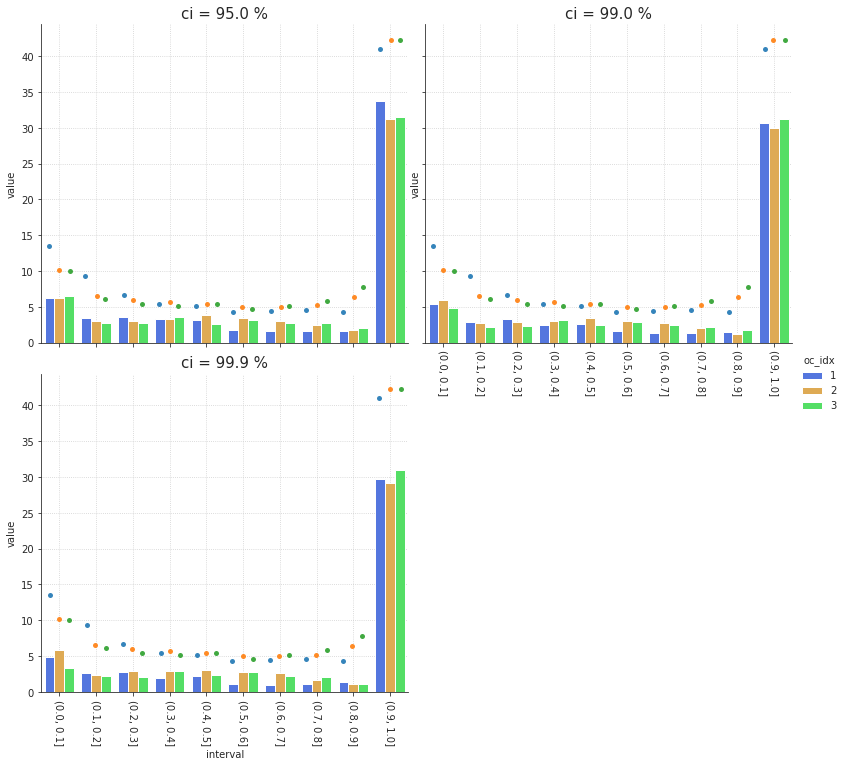

In [25]:
fg = sns.catplot(
    data=df_boot.loc[df_boot.label == 'lower'],
    x='interval',
    y='value',
    hue='oc_idx',
    kind='bar',
    col='ci',
    col_wrap=2,
    palette=svinet.colors,
    aspect=1.1,
    size=5,
    ci=None,
)
for i, ax in enumerate(fg.axes.ravel()):
    _df = df_boot.loc[
        (df_boot.label == 'median') &
        (df_boot.ci == df_boot.ci.unique()[i])
    ]
    sns.stripplot(
        data=_df,
        x='interval',
        y='value',
        hue='oc_idx',
        alpha=0.9,
        dodge=True,
        ax=ax,
    )
    ax.get_legend().remove()
    ax.grid(ls=':')
    ax.tick_params(axis='x', rotation=-90)
    ax.set_title(ax.title.get_text() + ' %', fontsize=15)
    if i < 2:
        ax.set_xlabel('')
    
file = pjoin(figs_dir, f"ci-lower-group_seeds-avg_bins{len(intervals)}-boot{n_boot:1.0e}.pdf")
fg.fig.savefig(file, bbox_inches='tight')

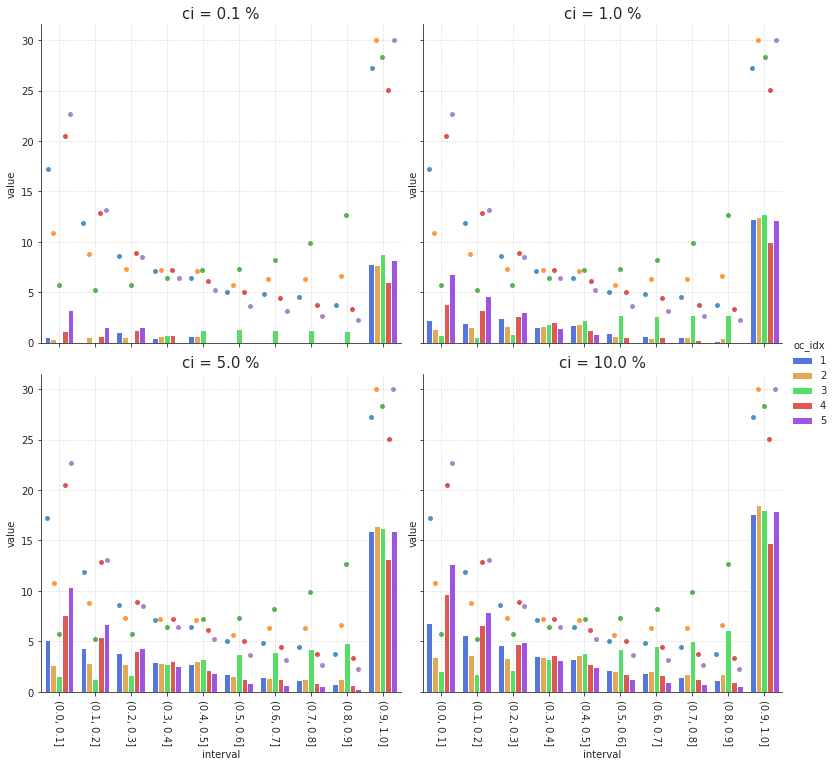

In [37]:
fg = sns.catplot(
    data=df_boot.loc[df_boot.label == 'lower'],
    x='interval',
    y='value',
    hue='oc_idx',
    kind='bar',
    col='ci',
    col_wrap=2,
    palette=svinet.colors,
    aspect=1.1,
    size=5,
    ci=None,
)
for i, ax in enumerate(fg.axes.ravel()):
    _df = df_boot.loc[
        (df_boot.label == 'median') &
        (df_boot.ci == df_boot.ci.unique()[i])
    ]
    sns.stripplot(
        data=_df,
        x='interval',
        y='value',
        hue='oc_idx',
        alpha=0.8,
        dodge=True,
        # jitter=False,
        # ci=None,
        # markers='.',
        # join=False,
        ax=ax,
    )
    ax.get_legend().remove()
    ax.grid(ls=':')
    ax.tick_params(axis='x', rotation=-90)
    ax.set_title(ax.title.get_text() + ' %', fontsize=15)
    if i < 2:
        ax.set_xlabel('')
    
file = pjoin(figs_dir, f"ci-lower-group_seed-single_bins{len(intervals)}-boot{nboot:1.0e}.pdf")
fg.fig.savefig(file, bbox_inches='tight')

In [20]:
 * (sys.getsizeof(booted) / 1e9) 

3.200000136

In [21]:
n_boot = int(1e7)
booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
)
booted.shape

  0%|          | 0/10000000 [00:00<?, ?it/s]

(100000000, 4, 10)

In [ ]:
fg = sns.catplot(
    data=df_boot.loc[df_boot.label == 'lower'],
    x='interval',
    y='value',
    hue='oc_idx',
    kind='bar',
    col='ci',
    col_wrap=2,
    palette=svinet.colors,
    aspect=1.1,
    size=5,
    ci=None,
)
for i, ax in enumerate(fg.axes.ravel()):
    _df = df_boot.loc[
        (df_boot.label == 'median') &
        (df_boot.ci == df_boot.ci.unique()[i])
    ]
    sns.stripplot(
        data=_df,
        x='interval',
        y='value',
        hue='oc_idx',
        alpha=0.9,
        dodge=True,
        ax=ax,
    )
    ax.get_legend().remove()
    ax.grid(ls=':')
    ax.tick_params(axis='x', rotation=-90)
    ax.set_title(ax.title.get_text() + ' %', fontsize=15)
    if i < 2:
        ax.set_xlabel('')
    
file = pjoin(figs_dir, f"ci-lower-group_seed-single_bins{len(intervals)}-boot{n_boot:1.0e}.pdf")
fg.fig.savefig(file, bbox_inches='tight')

## PointPlot

In [28]:
p = 20

dlist = []
for k in tqdm([4, 5, 6, 7]):
    if k != 4:
        continue
    for sub in tqdm(mice.cfg.sub_ids, leave=False):
        for ses in tqdm(mice.cfg.ses_ids, leave=False):
            key = mice.get_key(sub, ses)
            svinet = SVINET(
                mice=mice,
                num_k=k,
                perc=p,
                key=key,
                mode=mode,
                metric=metric,
                match_metric=match_metric,
                match_using=match_using,
                graph_type='real',
                verbose=False,
            ).load_results(full_process=False)

            _df = svinet.pi_cut_df.drop(columns='run')
            intervals = _df.interval.unique()
            data = _df.percent.to_numpy().reshape(-1, k, len(intervals))
            data = data[:, list(perms[key].values()), :]
            
            for i in range(data.shape[1]):
                for j in range(data.shape[2]):
                    alpha, loc, beta = sp_stats.gamma.fit(data[:, i, j], floc=-1e-10)
                    _result = {
                        'alpha': alpha,
                        'loc': loc,
                        'beta': beta,
                        'mean_est': alpha / beta,
                        'dispersion': 1 / alpha,
                        'mean': np.mean(data[:, i, j]),
                        'median': np.median(data[:, i, j]),
                        'median_w': np.nan,
                    }
                    dlist.append({
                        'param': _result.keys(),
                        'value': _result.values(),
                        'subject': [sub] * len(_result),
                        'session': [ses] * len(_result),
                        'interval': [intervals[j]] * len(_result),
                        'oc_idx': [i + 1] * len(_result),
                        'k': [k] * len(_result),
                    })
df_gamma = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
intervals = df_gamma.interval.unique()

In [30]:
for k in df_gamma.k.unique():
    for intvl in intervals:
        for sub in mice.cfg.sub_ids:
            median = np.zeros((3, k))
            disper = np.zeros((3, k))
            for ses in mice.cfg.ses_ids:
                _df = df_gamma.loc[
                    (df_gamma.k == k) &
                    (df_gamma.interval == intvl) &
                    (df_gamma.subject == sub) &
                    (df_gamma.session == ses)
                ]
                median[ses - 1] = _df.loc[_df.param == 'median', 'value'].values
                disper[ses - 1] = _df.loc[_df.param == 'dispersion', 'value'].values
            median_w = ((median * disper) / disper.sum(axis=0, keepdims=True)).sum(0)

            cond = (
                (df_gamma.subject == sub) &
                (df_gamma.interval == intvl) &
                (df_gamma.k == k) &
                (df_gamma.param == 'median_w')
            )
            df_gamma.loc[cond & (df_gamma.session == 1), 'value'] = median_w
            df_gamma.loc[cond, 'session'] = -1

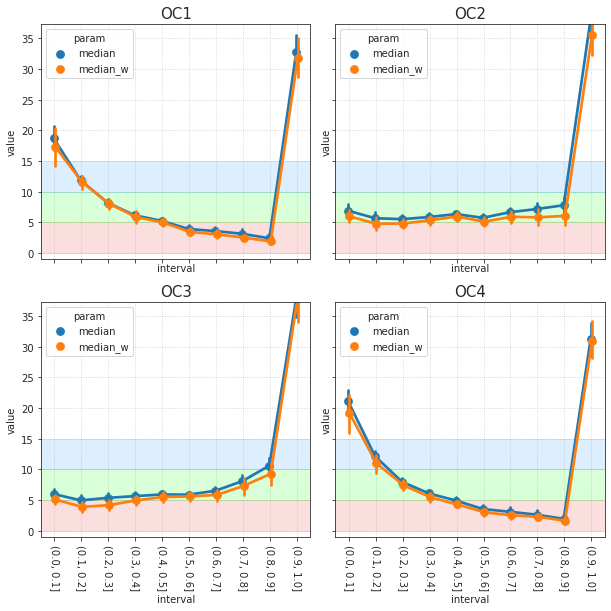

In [59]:
k = 4

nrows = 2
ncols = int(np.ceil(k / nrows))
fig, axes = create_figure(nrows, ncols, (4.3 * ncols, 4.3 * nrows), 'ticks', 'all', 'all')

for ax, oc_idx in zip(axes.ravel(), range(1, k + 1)):
    _df = df_gamma.loc[
        (df_gamma.param.isin(['median', 'median_w'])) &
        (df_gamma.k == k) &
        (df_gamma.oc_idx == oc_idx)
    ]
    sns.pointplot(
        data=_df,
        x='interval',
        y='value',
        hue='param',
        dodge=True,
        lw=1,
        ax=ax,
    )
    ax.tick_params(axis='x', rotation=-90)
    ax.set_ylim([-1, ax.get_ylim()[1]])
    ax.grid(axis='both', ls=':')
    ax.set_title(f"OC{oc_idx}", fontsize=15)
    ax.axhspan(0, 5, color='lightcoral', alpha=0.25, zorder=1)
    ax.axhspan(5, 10, color='lime', alpha=0.15, zorder=1)
    ax.axhspan(10, 15, color='dodgerblue', alpha=0.15, zorder=1)
_ = trim_axs(axes, k)
plt.show()